# Exercise 5

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Statistical testing: Theory

1) In statistical hypothesis testing, what does a *significant difference* mean? Use an example for illustration, e.g., the difference in weight of domestic and feral cats.
<br>
*null hypothesis (new datapoint belongs to distribution of previous data) has probabilty of <0.05*  

1) Given the same example as you used in 1), what is your null hypothesis ($H_0$) and what is your alternate hypothesis ($H_1$)?
<br>
*$H_1$: new datapoint belongs to distribution of previous data*

1) When conducting a statistical test, one important outcome is a so called *p-value*. What is a p-value? Explain using the same example as you used in 1).
<br>
*p: $P(X=x_{test})$ for $\mathcal{N(mu,sig)}$ or other distribution*

1) Now, we have compared the weight of domestic and feral cats using a statistical test: what does a p-value of `p=0.01` mean?
<br>
*chance is 0.01 that the value belongs to the assumed distribution of previous data*

1) What level ($\alpha$) of p-value would you use if you did a statistical test that causes ...
    1) ... someone to go to jail.
    1) ... a patient to take cough sirup.

1) Going back to our cat example,

    1) if the calculated p-value does not pass your $\alpha$ level, does that mean that the weight of domestic and feral cats is NOT different? Explain.
    *No, it is still possible with a chance of 1-p*
    1) if the calculated p-value passes your $\alpha$ level, what do you conclude?


1) What is a Type I and a Type II error?
<br>
*Type I: $H_0$ is true, but $H_1$ was assumed, due to classification boundary, or p-Value --> false positive*
<br>
*Type II: $H_1$ is true, but $H_0$ is assumed --> false negative*

## Statistical tests: Examples

In [ ]:
from scipy.stats import ranksums, ttest_ind

### Comparing the difference of two (normal) distributions

1) What is the null hypothesis of the Wilcoxon Rank-Sum test (also known as Mann-Whitney U test)?
1) The following code generates data from two distributions and calculates the *p-value* based on the Wilcoxon Rank-Sum test. Try different `n_samples`, and `shift`. Describe your observations.
1) Could you also use the t-test for this data? Check the corresponding [Wikipedia entry, Section 'Uses'](https://en.wikipedia.org/wiki/Student%27s_t-test#Uses).

RanksumsResult(statistic=0.19058433319583615, pvalue=0.8488512655032039)

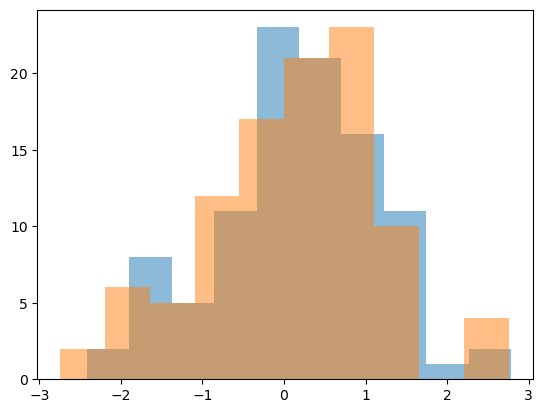

In [ ]:
# settings
n_samples = 100
shift = 0.2
variance = 1

# generate data
v1 = np.random.normal(size=n_samples)
v2 = np.random.normal(shift, variance, size=n_samples)
plt.hist(v1, alpha=0.5)
plt.hist(v2, alpha=0.5);

# perform the test
ranksums(v1, v2)

### Correlations

1) Intuitively, what does the Pearson correlation coefficient measure? What is its minimum and maximum value and what do different values mean?
2) How to interpret a p-value calculated for Pearson correlation?  
3) In what way is Spearman correlation different from Pearson?
4) Look at the generated data below and run the code. Try different `n_samples` and `covariance` values. What do you observe?
5) Add the outlier of `(0, 99)` to the data. What do you observe?
6) Calculate the Spearman correlation (`scipy.stats.spearmanr`) as well as Kendall's tau (`scipy.stats.kendalltau`). How does the outlier influence these correlation measures?

In [ ]:
from scipy.stats import spearmanr, pearsonr, kendalltau

r=0.06992005432325617, p=0.6294538874318618


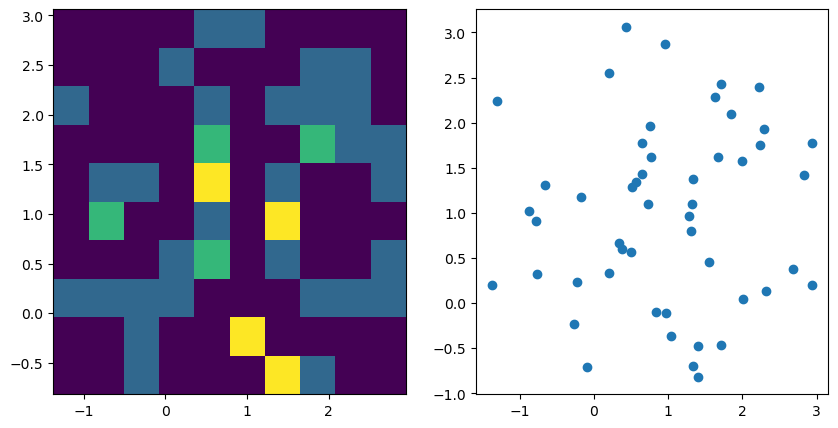

In [ ]:
# try different sample sizes and covariances

n_samples = 50

# use values from -1 to 1
covariance = 0

# generate data
d = np.random.multivariate_normal((1,1), [[1,covariance],[covariance,1]], n_samples)
v1 = d[:,0]
v2 = d[:,1]

# plot
fig, axes = plt.subplots(1,2, figsize=(2 * 5, 1 * 5))
ax = axes[0]; ax.hist2d(v1, v2)
ax = axes[1]; ax.scatter(v1, v2)

# stats
r, p = pearsonr(v1, v2)
print(f"r={r}, p={p}")

## Multiple hypothesis comparison

1) Explain what the multiple hypothesis comparison is and why it is a problem (refer to p-values in the process).
2) Execute the following code, experiment with `n_samples` and `p_threshold`, and explain what it does.

In [ ]:
# multiple hypothesis comparision and correction on real data
# try different p_thresholds (also called alpha values) and sample sizes

# parameters
n_samples = 1000
n_features = 1000
p_threshold = 0.05  # alpha value

# generate data
X = np.random.random((n_samples, n_features))
y = np.random.random(n_samples)

# calculate p-values between all features and the target
ps = []
for i in range(X.shape[1]):
    r, p = spearmanr(X[:,i], y)
    ps.append(p)

# report results

print(f"# of tests with p < {p_threshold} without correction: ", (np.array(ps) < p_threshold).sum())

from statsmodels.stats.multitest import multipletests
ps2 = multipletests(ps, method="fdr_bh")[1]
print(f"# of tests with p < {p_threshold} WITH correction: ", (np.array(ps2) < p_threshold).sum())

# of tests with p < 0.05 without correction:  46
# of tests with p < 0.05 WITH correction:  0


## Model comparison

1) Run the given code. What does it do?
1) Adjust the given code to use *repeated* cross-validation (`StratifiedRepeatedKFold`) for three different models (add one model). Why are we using a `stratified` version here?
1) Run the training several times with different numbers of repetitions (1, 10, 100). What do you observe?
1) Compare your performance values using [Wilcoxon rank-sum test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ranksums.html). Again, compare different numbers of repetitions. What do you observe?
1) Is one of the two models significantly better? Why?
1) Retrain the "better" model on the whole training dataset and plot your predictions (`predict_proba`) for the training and test data.

In [ ]:
# imports
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, RepeatedStratifiedKFold

from sklearn.pipeline import make_pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# load data
data_titanic = pd.read_csv("exercise_01_intro-to-python_titanic.csv", index_col="PassengerId")

In [ ]:
def extract_features(data):
    """Extract features from existing variables"""

    data_extract = data.copy()

    # name
    name_only = data_extract["Name"].str.replace(r"\(.*\)", "", regex=True)
    first_name = name_only.str.split(", ", expand=True).iloc[:,1]
    title = first_name.str.split(".", expand=True).iloc[:,0]
    data_extract["Title"] = title

    # ticket

    # ...

    return data_extract

data_extract = extract_features(data_titanic)

In [ ]:
def preprocess(data):
    """Convert features into numeric variables readable by our models."""

    data_preprocessed = data.copy()

    # Sex

    data_preprocessed = pd.get_dummies(data_preprocessed, columns=["Sex"], drop_first=True)

    # Embarked

    data_preprocessed = pd.get_dummies(data_preprocessed, columns=["Embarked"], dummy_na=True)

    # Title
    title = data_preprocessed["Title"]
    title_counts = title.value_counts()
    higher_titles = title_counts[title_counts < 50]
    title_groups = ["higher" if t in higher_titles else t for t in title]
    data_preprocessed["Title"] = title_groups
    data_preprocessed = pd.get_dummies(data_preprocessed, columns=["Title"])

    # drop the rest
    data_preprocessed.drop(columns=["Name", "Cabin", "Ticket"], inplace=True)

    return data_preprocessed

data_preprocessed = preprocess(data_extract)

In [ ]:
# before inspecting the data, selecting and building models, etc.
# FIRST split data into train and test data (we set the test data size to 30%)

X = data_preprocessed.drop(columns="Survived")
y = data_preprocessed["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [ ]:
def evaluate(model, name, scoring="accuracy"):
    results = cross_validate(
        model,
        X_train, y_train,
        cv=StratifiedKFold(n_splits=5),
        scoring=scoring,
        return_train_score=True)

    results = pd.DataFrame(results)
    results["model"] = name

    display(f"Train ({scoring}): {results['train_score'].mean():.02f} +/- {results['train_score'].std():.02f}")
    display(f"Test  ({scoring}): {results['test_score'].mean():.02f} +/- {results['test_score'].std():.02f}")
    return results

In [ ]:
results = []

In [ ]:
imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()
model_lr = LogisticRegression()

pipeline_lr = make_pipeline(imputer, scaler, model_lr)
results_lr = evaluate(pipeline_lr, "logistic regression")
results.append(results_lr)

'Train (accuracy): 0.81 +/- 0.01'

'Test  (accuracy): 0.80 +/- 0.03'

In [ ]:
imputer = SimpleImputer(strategy="median")
model_tree = DecisionTreeClassifier(max_depth=3)

pipeline_tree = make_pipeline(imputer, model_tree)
results_dt = evaluate(pipeline_tree, "decision tree")
results.append(results_dt)

'Train (accuracy): 0.81 +/- 0.01'

'Test  (accuracy): 0.80 +/- 0.03'

In [ ]:
# # another model
# imputer = SimpleImputer(strategy="median")
# model_svm = SVC()

# pipeline_svm = make_pipeline(imputer, model_svm)
# results_svm = evaluate(pipeline_svm, "svm")
# results.append(results_svm)

<Axes: xlabel='model', ylabel='test_score'>

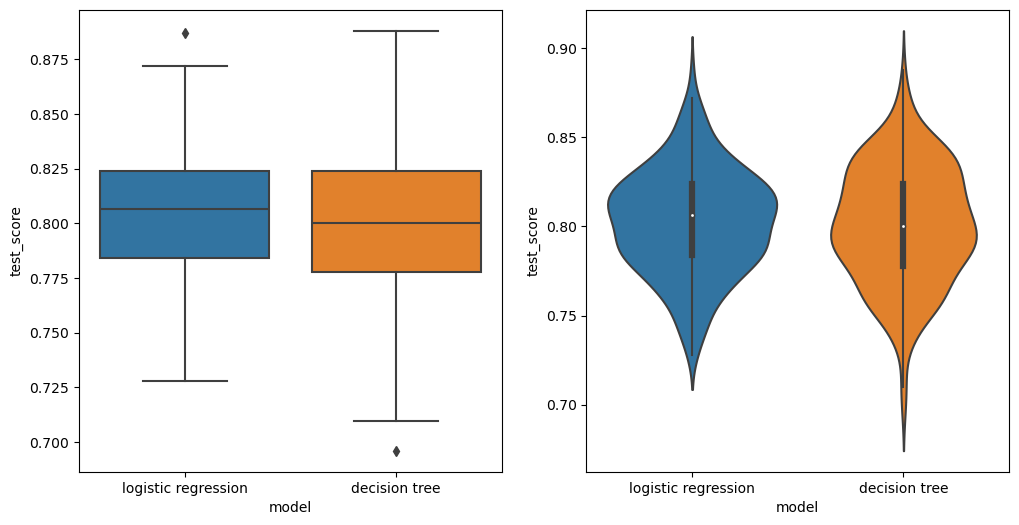

In [ ]:
results_df = pd.concat(results)

fig, axes = plt.subplots(1, 2, figsize=(2 * 6, 6))
ax = axes[0]
sns.boxplot(data=results_df, x="model", y="test_score", ax=ax)
ax = axes[1]
sns.violinplot(data=results_df, x="model", y="test_score", ax=ax)

In [ ]:
# compare
from scipy.stats import ranksums

test_score_lr = results_df.loc[results_df["model"] == "logistic regression", "test_score"]
test_score_dt = results_df.loc[results_df["model"] == "decision tree", "test_score"]

# ...

## Model introspection

The following code plots feature importances for a linear model.

1) Try different data splits. What do you observe?
1) Try adding and removing individual features. What do you observe?
1) Try scaling individual features. What do you observe?
1) Are the features that are considered important according to a model the only possibly important features to make predictions?

In [ ]:
# before inspecting the data, selecting and building models, etc.
# FIRST split data into train and test data (we set the test data size to 30%)

X = data_preprocessed.drop(columns="Survived")
y = data_preprocessed["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [ ]:
imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()
preprocessing_pipeline = make_pipeline(scaler, imputer)


X_train_example = X_train.copy()

# TODO: drop features here
# ...

X_train_processed = preprocessing_pipeline.fit_transform(X_train_example)

# TODO: change `X_train_processed` for example here
# ...

# set model
model = LogisticRegression()

# fit for coefficient extraction
model.fit(X_train_processed, y_train)
feature_weights = model.coef_.flatten()

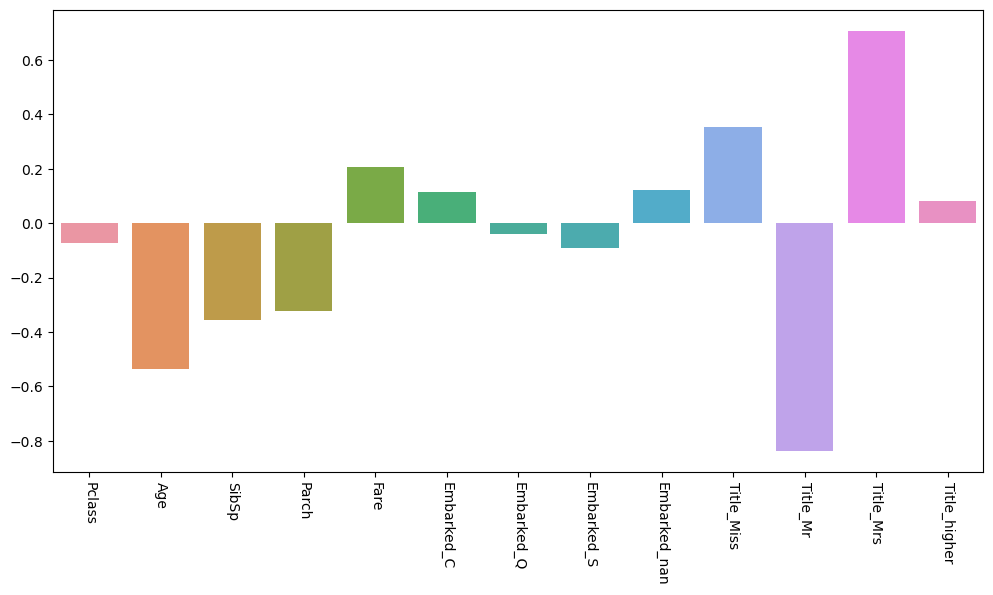

In [ ]:
# plot feature importances
fig, ax = plt.subplots(1, 1, figsize=(6 * 2, 6), sharey=True)
sns.barplot(x=X_train_example.columns, y=feature_weights, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=270)
plt.show()